### 1.載入套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 2.載入資料並進行處理

In [3]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

### 3.架構VAE模型

In [4]:
enc_1 = Dense(200, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [5]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

* 抽樣函數

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [8]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [23]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          157000      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            402         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            402         dense[0][0]                      
____________________________________________________________________________________________

* Loss Function

In [24]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [25]:
VAE.compile(optimizer=Adam(7e-3))

In [27]:
VAE.fit(X_train, batch_size=256, epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 68us/sample - loss: 51.4801
Epoch 2/20
60000/60000 [==============================] - 3s 47us/sample - loss: 46.5436
Epoch 3/20
60000/60000 [==============================] - 3s 47us/sample - loss: 45.0541
Epoch 4/20
60000/60000 [==============================] - 3s 47us/sample - loss: 43.0890
Epoch 5/20
60000/60000 [==============================] - 3s 47us/sample - loss: 41.7526
Epoch 6/20
60000/60000 [==============================] - 3s 47us/sample - loss: 40.9804
Epoch 7/20
60000/60000 [==============================] - 3s 47us/sample - loss: 40.3606
Epoch 8/20
60000/60000 [==============================] - 3s 48us/sample - loss: 39.8501
Epoch 9/20
60000/60000 [==============================] - 3s 47us/sample - loss: 39.4352
Epoch 10/20
60000/60000 [==============================] - 3s 47us/sample - loss: 39.0735
Epoch 11/20
60000/60000 [==============================] - 3s 47us/sample - loss: 38.7

In [28]:
VAE.save_weights('VAE_model_weights6.h5')

In [29]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [30]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               157584    
Total params: 158,184
Trainable params: 158,184
Non-trainable params: 0
_________________________________________________________________


In [31]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 55510 圖的 latent 表示為 [0.3660816 1.373793 ]


In [32]:
indice = np.random.randint(X_train.shape[0],size=5000)

In [33]:
VAE_Encoder.predict(X_train[indice])

array([[ 1.1900805 ,  1.9041173 ],
       [ 0.69825554, -1.4377283 ],
       [-0.6564202 ,  0.67693484],
       ...,
       [-0.4109514 ,  1.4859068 ],
       [ 0.83776873, -0.4304093 ],
       [-0.43938377,  0.71866   ]], dtype=float32)

In [34]:
#VAE_Encoder.predict(X_train[indice])

In [35]:
VAE_latents = VAE_Encoder.predict(X_train[indice])

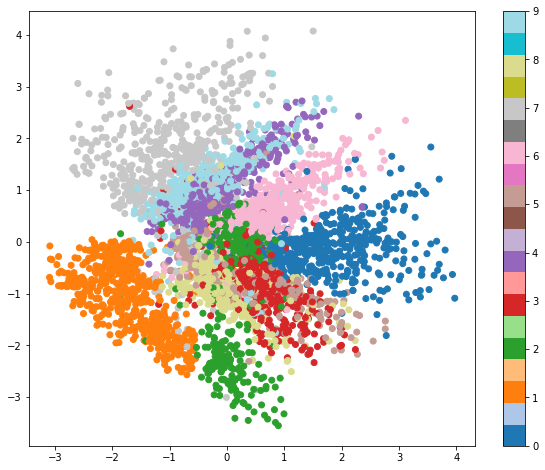

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indice], cmap='tab20')
plt.colorbar()
plt.show()

In [37]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [38]:
n=16
digit_size=28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

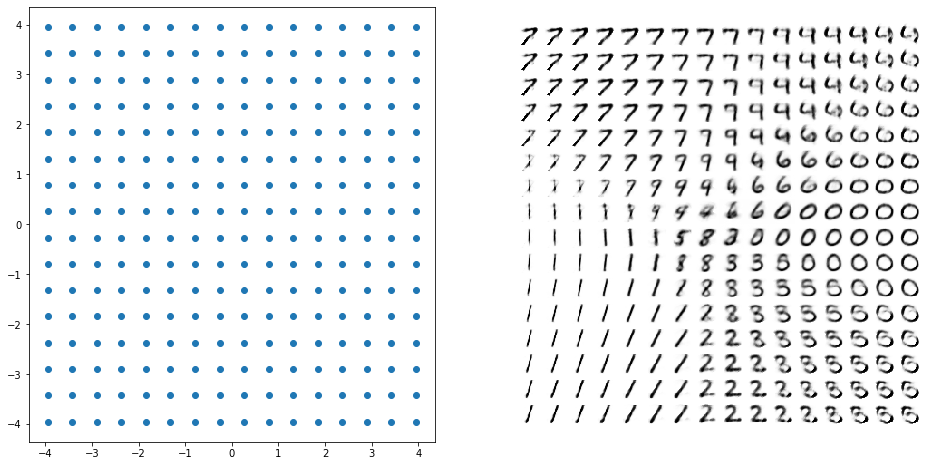

In [39]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()